# Model Testing

In [41]:
import os
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_roc_curve, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, normalize
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# saving scaler
import pickle

# extreme gradient boosting
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree

# eli5 for feature importances
import eli5
from eli5.sklearn import PermutationImportance

# from sklearn.cluster import KMeans
# from scipy.cluster.vq import kmeans2

# This line is needed to display plots inline in Jupyter Notebook
%matplotlib inline

# Required for basic python plotting functionality
import matplotlib.pyplot as plt

# Required for formatting dates later in the case
import datetime
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
from tqdm import tqdm

# Advanced plotting functionality with seaborn
import seaborn as sns
import warnings


sns.set(style="whitegrid")  # can set style depending on how you'd like it to look

## testing

In [42]:
df = pd.read_csv('../leap-data/training-data.csv')
df = df.drop(columns=['id', df.columns[-1]])
df.columns = [col.strip() for col in df.columns]

In [43]:
df.head()

,label,s,tx,ty,tz,r11,r12,r13,r21,r22,...,pinkie_int_dir_3,pinkie_dist_center_1,pinkie_dist_center_2,pinkie_dist_center_3,pinkie_dist_dir_1,pinkie_dist_dir_2,pinkie_dist_dir_3,pinkie_tip_pos_1,pinkie_tip_pos_2,pinkie_tip_pos_3
0,a,0.530613,5.66636,-12.79560,-36.7602,-0.612260,-0.506043,-0.607502,-0.136662,-0.689055,...,-0.042461,24.5667,108.259,18.69510,0.853832,-0.518814,-0.042461,29.2316,98.872,25.75520
1,a,0.172742,62.12970,-8.63909,-82.3020,0.900943,-0.387331,0.195646,0.233361,0.812581,...,0.093596,26.5309,112.363,-1.41106,0.815760,-0.570767,0.093596,26.4443,109.361,-6.36915
2,a,0.215332,50.29570,4.45456,-44.5697,0.970315,-0.116096,0.212159,0.025461,0.921409,...,-0.051356,20.9811,110.391,-12.51030,0.898600,-0.435752,-0.051356,17.3276,100.707,-4.96892
3,a,0.272220,80.48790,7.88156,-79.7281,0.954342,-0.195743,0.225645,0.071769,0.883507,...,0.050731,72.6394,121.462,4.39365,0.852042,-0.521009,0.050731,66.6906,114.068,-8.40204
4,a,1.146190,43.83230,-30.40940,-38.5348,0.983444,-0.059767,0.171071,0.070797,0.995737,...,0.247188,90.3739,116.587,11.62320,0.819272,-0.517389,0.247188,83.8689,113.521,23.75930


In [44]:
# find columns that we have to transform
full_names = list(set([val[:-2] for val in df.columns.values \
                        if 'center' in val or 'pos' in val or 'dir' in val]))
full_names

['index_int_dir',
 'thumb_tip_pos',
 'index_prox_center',
 'ring_dist_dir',
 'index_tip_pos',
 'middle_prox_center',
 'thumb_int_center',
 'pinkie_int_dir',
 'middle_dist_dir',
 'pinkie_dist_center',
 'thumb_dist_center',
 'thumb_prox_dir',
 'ring_prox_center',
 'hand_dir',
 'middle_dir',
 'middle_int_center',
 'middle_tip_pos',
 'middle_dist_center',
 'index_dist_center',
 'pinkie_int_center',
 'thumb_meta_center',
 'pinkie_dist_dir',
 'thumb_prox_center',
 'thumb_meta_dir',
 'index_dist_dir',
 'pinkie_tip_pos',
 'pinkie_prox_dir',
 'ring_int_dir',
 'index_dir',
 'pinkie_meta_center',
 'index_meta_center',
 'ring_dir',
 'ring_tip_pos',
 'ring_meta_center',
 'middle_prox_dir',
 'thumb_int_dir',
 'ring_prox_dir',
 'ring_int_center',
 'thumb_dist_dir',
 'ring_meta_dir',
 'ring_dist_center',
 'pinkie_prox_center',
 'index_prox_dir',
 'middle_meta_dir',
 'pinkie_dir',
 'index_int_center',
 'middle_meta_center',
 'middle_int_dir',
 'pinkie_meta_dir',
 'index_meta_dir',
 'thumb_dir']

In [45]:
# naive test
X = df[df.columns[1:]]

def un_rotate():
    for index, row in tqdm(X.iterrows()):
        Rinv = np.linalg.inv(np.array([
            [row['r11'], row['r12'], row['r13']],
            [row['r21'], row['r22'], row['r23']],
            [row['r31'], row['r32'], row['r33']],
        ]))
        t0 = np.array([row['tx'], row['ty'], row['tz']])
        for vec in full_names:
            coord = np.array([row[vec+'_1'], row[vec+'_2'], row[vec+'_3']])
            if 'center' in vec or 'pos' in vec:
                coord -= t0
                coord /= row['s']
                coord = Rinv @ coord
            else: 
                coord = Rinv @ coord
                coord /= np.linalg.norm(coord)
            row[vec+'_1'], row[vec+'_2'], row[vec+'_3'] = coord

# un_rotate()

y = df['label']
def replace_letter_with_number(c):
    return ord(c.strip()) - ord('a')
y = y.apply(replace_letter_with_number)


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# 0.25 x 0.666 = 0.167
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

In [48]:
def naive_scale():
    scaler = StandardScaler()
    scaler.fit(X_train)
    scaler.transform(X_train)
    scaler.transform(X_test)

    with open('./scaler.pkl','wb') as f:
        pickle.dump(scaler, f)

#naive_scale()

/Users/Sathya/anaconda3/envs/pyrecent/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.92053	validation_1-mlogloss:2.12414
[1]	validation_0-mlogloss:1.39041	validation_1-mlogloss:1.66668
[2]	validation_0-mlogloss:1.07141	validation_1-mlogloss:1.38108
[3]	validation_0-mlogloss:0.85604	validation_1-mlogloss:1.18165
[4]	validation_0-mlogloss:0.69746	validation_1-mlogloss:1.03737
[5]	validation_0-mlogloss:0.57885	validation_1-mlogloss:0.92198
[6]	validation_0-mlogloss:0.48686	validation_1-mlogloss:0.83393
[7]	validation_0-mlogloss:0.41596	validation_1-mlogloss:0.76302
[8]	validation_0-mlogloss:0.35952	validation_1-mlogloss:0.70597
[9]	validation_0-mlogloss:0.31478	validation_1-mlogloss:0.65939
[10]	validation_0-mlogloss:0.27848	validation_1-mlogloss:0.62239
[11]	validation_0-mlogloss:0.24874	validation_1-mlogloss:0.59253
[12]	validation_0-mlogloss:0.22493	validation_1-mlogloss:0.56759
[13]	validation_0-mlogloss:0.20515	validation_1-mlogloss:0.54711
[14]	validation_0-mlogloss:0.18837	validation_1-mlogloss:0.52846
[15]	validation_0-mlogloss:0.17517	

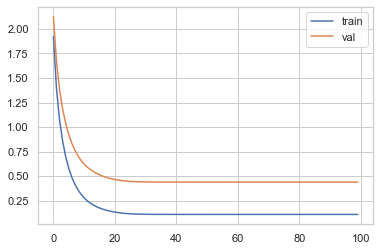

In [49]:
model = xgb.XGBClassifier(reg_alpha = 3, reg_lambda=4)
evalset = [(X_train, y_train), (X_val,y_val)]
model.fit(X_train, y_train, eval_metric='mlogloss', eval_set=evalset)

# model training results
results = model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='val')
plt.legend()

In [50]:
y_pred = model.predict(X_test)

# confusion mat
mat = confusion_matrix(y_test, y_pred)

# classification report
print(classification_report(y_test, y_pred))

# raw accuracy 
score = accuracy_score(y_test, y_pred)
print("Accuracy score is", score)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       0.91      1.00      0.96        32
           2       0.97      0.91      0.94        34
           3       0.91      0.74      0.82        27
           4       0.91      0.83      0.87        35
           5       0.97      0.95      0.96        37
           6       0.91      0.82      0.86        38
           7       0.92      1.00      0.96        33
           8       1.00      0.97      0.98        31
           9       0.98      0.98      0.98        45
          10       0.90      0.96      0.93        28
          11       0.97      0.97      0.97        33
          12       0.77      0.79      0.78        29
          13       0.71      0.71      0.71        38
          14       0.93      1.00      0.97        28
          15       0.94      0.89      0.92        38
          16       1.00      0.95      0.97        38
          17       0.97    

In [51]:
roc_auc_score(y_test.values, model.predict_proba(X_test.values), multi_class='ovr')

0.9964697834972396

In [52]:
# feature importances
sorted(list(zip(X.columns, model.feature_importances_)), key=lambda x: -x[1], )

[('pinkie_meta_center_3', 0.05283805),
 ('index_prox_dir_2', 0.04304045),
 ('thumb_meta_dir_2', 0.041472685),
 ('index_prox_dir_3', 0.041242328),
 ('middle_meta_center_3', 0.030463802),
 ('pinkie_meta_dir_3', 0.02881318),
 ('ring_dir_1', 0.027813256),
 ('index_int_center_3', 0.026213422),
 ('pinkie_dir_3', 0.024545852),
 ('pinkie_meta_dir_1', 0.023611542),
 ('ring_meta_center_2', 0.022749182),
 ('index_meta_dir_1', 0.022148399),
 ('middle_prox_center_3', 0.019323474),
 ('thumb_meta_center_2', 0.019263938),
 ('ring_dir_3', 0.01896063),
 ('thumb_int_center_1', 0.018883374),
 ('ring_meta_center_3', 0.01853124),
 ('index_meta_dir_2', 0.017771862),
 ('index_meta_center_3', 0.016612958),
 ('index_dir_2', 0.0147401),
 ('index_meta_dir_3', 0.014628615),
 ('ring_int_center_3', 0.014158183),
 ('thumb_meta_dir_3', 0.014138586),
 ('thumb_dir_3', 0.013518898),
 ('r12', 0.013345643),
 ('ring_meta_dir_2', 0.0129787065),
 ('middle_prox_dir_1', 0.012826644),
 ('middle_dir_3', 0.012154696),
 ('index_dir

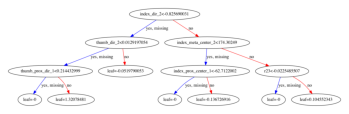

In [53]:
plot_tree(model, filled=True, num_trees=4)
plt.savefig('xgboost_tree.png', dpi=330, bbox_inches='tight')

Text(89.18, 0.5, 'predicted label')

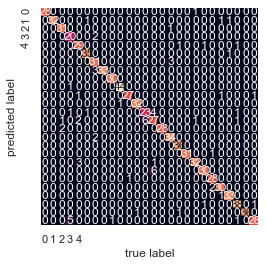

In [54]:
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(range(5)), yticklabels=list(range(5)))
plt.xlabel('true label')
plt.ylabel('predicted label')

In [55]:
model.save_model('alphabet.json')